In [1]:
import pandas as pd
from pyha_analyzer import config
from pyha_analyzer.dataset import get_datasets, make_dataloaders, PyhaDFDataset
from pyha_analyzer.utils import set_seed
from pyha_analyzer.models.early_stopper import EarlyStopper
from pyha_analyzer.models.timm_model import TimmModel
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import os
import librosa
import torch
import wandb
import random

import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from tqdm import tqdm
import torch.nn.functional as F
# %%
import pandas as pd
from pyha_analyzer.train import run_batch
from pyha_analyzer.dataset import get_datasets, make_dataloaders, PyhaDFDataset
from pyha_analyzer import config
from pyha_analyzer.models.timm_model import TimmModel
import logging
torch.multiprocessing.set_sharing_strategy('file_system')
torch.multiprocessing.set_start_method('spawn')
wandb.init()
cfg = config.cfg

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jiw220 (acoustic-species-identification). Use `wandb login --relogin` to force relogin


In [2]:
import matplotlib.pyplot as plt

In [ ]:
random.seed(0)
torch.manual_seed(0)

TypeError: seed() takes 0 positional arguments but 1 was given

In [ ]:
#passive-acoustic-biodiversity/ground_truth_soundscapes/ArbimonCopy/abrimon_copy_ground_truth_input_for_pyhadataset.csv
csv_file = "abrimon_copy_ground_truth_input_for_pyhadataset_new1.csv"
root = "/data/test_data/ArbimonCopy/"
weights = "/home/jiw220/acoustic-multiclass-training/models/eca_nfnet_l0-20250421-0342.pt"
skip=False

In [ ]:
df = pd.read_csv(root + csv_file)
df

,Unnamed: 0,FILE_NAME,OFFSET,DURATION,MANUAL ID,file_location
0,0,T:\Peru\ArbimonCopy\Tahuamanu 2017\2_No\defaul...,0,5,amabaw1,Tahuamanu 2017/2_No/default-2017-07-06_08-20.flac
1,1,T:\Peru\ArbimonCopy\Tahuamanu 2017\2_No\defaul...,5,5,amabaw1,Tahuamanu 2017/2_No/default-2017-07-06_08-20.flac
2,2,T:\Peru\ArbimonCopy\Tahuamanu 2017\2_No\defaul...,10,5,amabaw1,Tahuamanu 2017/2_No/default-2017-07-06_08-20.flac
3,3,T:\Peru\ArbimonCopy\Tahuamanu 2017\2_No\defaul...,15,5,amabaw1,Tahuamanu 2017/2_No/default-2017-07-06_08-20.flac
4,4,T:\Peru\ArbimonCopy\Tahuamanu 2017\2_No\defaul...,20,5,amabaw1,Tahuamanu 2017/2_No/default-2017-07-06_08-20.flac
...,...,...,...,...,...,...
45883,45883,T:\Peru\ArbimonCopy\RFE\71_RFE\default-2017-10...,35,5,amabaw1,RFE/71_RFE/default-2017-10-23_07-40.flac
45884,45884,T:\Peru\ArbimonCopy\RFE\71_RFE\default-2017-10...,40,5,amabaw1,RFE/71_RFE/default-2017-10-23_07-40.flac
45885,45885,T:\Peru\ArbimonCopy\RFE\71_RFE\default-2017-10...,45,5,amabaw1,RFE/71_RFE/default-2017-10-23_07-40.flac
45886,45886,T:\Peru\ArbimonCopy\RFE\71_RFE\default-2017-10...,50,5,amabaw1,RFE/71_RFE/default-2017-10-23_07-40.flac


In [ ]:
#drop FILENAME column
df = df.drop(columns=['FILE_NAME'])

#rename file_location to FILENAME
df = df.rename(columns={'file_location': 'FILE NAME'})

In [ ]:
df = df[["OFFSET", "DURATION", "FILE NAME", "MANUAL ID"]]

In [ ]:
df

,OFFSET,DURATION,FILE NAME,MANUAL ID
0,0,5,Tahuamanu 2017/2_No/default-2017-07-06_08-20.flac,amabaw1
1,5,5,Tahuamanu 2017/2_No/default-2017-07-06_08-20.flac,amabaw1
2,10,5,Tahuamanu 2017/2_No/default-2017-07-06_08-20.flac,amabaw1
3,15,5,Tahuamanu 2017/2_No/default-2017-07-06_08-20.flac,amabaw1
4,20,5,Tahuamanu 2017/2_No/default-2017-07-06_08-20.flac,amabaw1
...,...,...,...,...
45883,35,5,RFE/71_RFE/default-2017-10-23_07-40.flac,amabaw1
45884,40,5,RFE/71_RFE/default-2017-10-23_07-40.flac,amabaw1
45885,45,5,RFE/71_RFE/default-2017-10-23_07-40.flac,amabaw1
45886,50,5,RFE/71_RFE/default-2017-10-23_07-40.flac,amabaw1


In [ ]:
classes = [
        'amabaw1', 'amapyo1', 'astgna1', 'baffal1', 'barant1', 'bartin2', 'batman1', 'blacar1', 'blbthr1', 'blcbec1', 'blctro1', 'blfant1', 'blfcot1', 'blfjac1', 'blfnun1', 'blgdov1', 'blhpar1', 'bltant2', 'blttro1', 'bobfly1', 'brratt1', 'bsbeye1', 'btfgle1', 'bubgro2', 'bubwre1', 'bucmot4', 'buffal1', 'butsal1', 'butwoo1', 'chwfog1', 'cinmou1', 'cintin1', 'citwoo1', 'coffal1', 'coltro1', 'compot1', 'cowpar1', 'crfgle1', 'ducatt1', 'ducfly', 'ducgre1', 'duhpar', 'dutant2', 'elewoo1', 'eulfly1', 'fasant1', 'fepowl', 'forela1', 'garkin1', 'gilbar1', 'gnbtro1', 'gocspa1', 'goeant1', 'gogwoo1', 'gramou1', 'grasal3', 'grcfly1', 'greant1', 'greibi1', 'gretin1', 'grfdov1', 'gryant1', 'gryant2', 'gycfly1', 'gycwor1', 'hauthr1', 'horscr1', 'letbar1', 'littin1', 'litwoo2', 'lobwoo1', 'lowant1', 'meapar', 'muswre2', 'olioro1', 'oliwoo1', 'partan1', 'pavpig2', 'pirfly1', 'plbwoo1', 'pltant1', 'pluant1', 'plupig2', 'plwant1', 'puteup1', 'putfru1', 'pygant1', 'rcatan1', 'rebmac2', 'renwoo1', 'rinant2', 'rinkin1', 'rinwoo1', 'royfly1', 'ruboro1', 'rucant2', 'rudpig', 'rufant3', 'ruftof1', 'ruqdov', 'scapig2', 'scbwoo5', 'scrpih1', 'sobcac1', 'specha3', 'spigua1', 'spwant2', 'squcuc1', 'stbwoo2', 'strcuc1', 'strwoo2', 'strxen1', 'stwqua1', 'tabsco1', 'thlwre1', 'undtin1', 'viotro3', 'wespuf1', 'whbtot1', 'whcspa1', 'whfant2', 'whltyr1', 'whnrob1', 'whrsir1', 'whttou1', 'whtwoo2', 'whwbec1', 'wibpip1', 'yectyr1', 'yemfly1', 'yercac1', 'yetwoo2'
        ]

In [ ]:
# Code for further processing
infer_dataset = PyhaDFDataset(df, train=False, species=classes, cfg=cfg)
infer_dataloader = DataLoader(
                    infer_dataset,
                    cfg.validation_batch_size,
                    shuffle=False,
                    num_workers=cfg.jobs,
                )

100%|██████████| 1944/1944 [00:02<00:00, 687.34it/s] 


In [ ]:
infer_dataset.samples.to_csv("_DATA_TO_RUN_ON_Matthias.csv")

In [ ]:
def run_batch(model,
                mels,
                labels,
                ):
    """ Runs the model on a single batch 
        Args:
            model: the model to pass the batch through
            mels: single batch of input data
            labels: single batch of expecte output
        Returns (tuple of):
            loss: the loss of the batch
            outputs: the output of the model
    """
    mels = mels.to(cfg.device)
    labels = labels.to(cfg.device)
    # if cfg.device == "cpu": 
    #     dtype = torch.bfloat16
    # else: 
    #     dtype = torch.float16
    # with autocast(device_type=cfg.device, dtype=dtype, enabled=cfg.mixed_precision):
    outputs = model(mels)
    loss = model.loss_fn(outputs, labels) # type: ignore
    outputs = outputs.to(dtype=torch.float32)
    loss = loss.to(dtype=torch.float32)
    return loss, outputs

In [ ]:
df_train = pd.read_csv("/data/test_data/ArbimonCopy/abrimon_copy_ground_truth_input_for_pyhadataset_new1.csv")
#renane FILE_NAME to FILE NAME
df_train = df_train.rename(columns={'FILE_NAME': 'FILE NAME'})
# take out "T:\Peru\ArbimonCopy\" from the file name and also replace all \ with /
df_train["FILE NAME"] = df_train["FILE NAME"].str.replace("T:\\Peru\\ArbimonCopy\\", "")
df_train["FILE NAME"] = df_train["FILE NAME"].str.replace("\\", "/")
df_train

,Unnamed: 0,FILE NAME,OFFSET,DURATION,MANUAL ID,file_location
0,0,Tahuamanu 2017/2_No/default-2017-07-06_08-20.flac,0,5,amabaw1,Tahuamanu 2017/2_No/default-2017-07-06_08-20.flac
1,1,Tahuamanu 2017/2_No/default-2017-07-06_08-20.flac,5,5,amabaw1,Tahuamanu 2017/2_No/default-2017-07-06_08-20.flac
2,2,Tahuamanu 2017/2_No/default-2017-07-06_08-20.flac,10,5,amabaw1,Tahuamanu 2017/2_No/default-2017-07-06_08-20.flac
3,3,Tahuamanu 2017/2_No/default-2017-07-06_08-20.flac,15,5,amabaw1,Tahuamanu 2017/2_No/default-2017-07-06_08-20.flac
4,4,Tahuamanu 2017/2_No/default-2017-07-06_08-20.flac,20,5,amabaw1,Tahuamanu 2017/2_No/default-2017-07-06_08-20.flac
...,...,...,...,...,...,...
45883,45883,RFE/71_RFE/default-2017-10-23_07-40.flac,35,5,amabaw1,RFE/71_RFE/default-2017-10-23_07-40.flac
45884,45884,RFE/71_RFE/default-2017-10-23_07-40.flac,40,5,amabaw1,RFE/71_RFE/default-2017-10-23_07-40.flac
45885,45885,RFE/71_RFE/default-2017-10-23_07-40.flac,45,5,amabaw1,RFE/71_RFE/default-2017-10-23_07-40.flac
45886,45886,RFE/71_RFE/default-2017-10-23_07-40.flac,50,5,amabaw1,RFE/71_RFE/default-2017-10-23_07-40.flac


In [ ]:
train_dataset = PyhaDFDataset(df_train, train=True, species=classes, cfg=cfg)

  0%|          | 0/1944 [00:00<?, ?it/s]

100%|██████████| 1944/1944 [00:00<00:00, 3659.07it/s]


In [ ]:
model_for_run = TimmModel(num_classes=len(classes), 
                            model_name=cfg.model).to(cfg.device)
model_for_run.create_loss_fn(train_dataset)
model_for_run.load_state_dict(torch.load(weights))

model = model_for_run

In [ ]:
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torch.nn.functional as F
import numpy as np
if not skip:
    #df = pd.read_csv(root + csv_file)
    df["file_location"] = df["FILE NAME"]
    cfg.data_path = root
    df["Species eBird Code"] = "gycwor1"
    peru_dataset = PyhaDFDataset(df, False, classes, cfg, False)
    peru_dataloader = DataLoader(
            peru_dataset,
            cfg.train_batch_size,
            num_workers=cfg.jobs,
            shuffle=False,
        )
    log_pred = []
    log_labels = []
    model.eval()
    with torch.no_grad():
        for i, (mels, labels) in enumerate(peru_dataloader):
            print((run_batch(model, mels, labels)[1] == run_batch(model, mels, labels)[1]).all())
            # _, outputs = run_batch(model, mels, labels)
            log_pred.append(np.array(torch.clone(F.sigmoid(outputs).cpu()).detach()))
            log_label.append(np.array(torch.clone(F.sigmoid(outputs).cpu()).detach()))
            if i % 20 == 19:
                
                



100%|██████████| 3824/3824 [00:00<00:00, 333181.38it/s]


100%|██████████| 1944/1944 [00:00<00:00, 2633.93it/s]


tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(Tru

[W CudaIPCTypes.cpp:15] Producer process has been terminated before all shared CUDA tensors released. See Note [Sharing CUDA tensors]


In [ ]:
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torch.nn.functional as F
import numpy as np
if not skip:
    #df = pd.read_csv(root + csv_file)
    df["file_location"] = df["FILE NAME"]
    cfg.data_path = root
    df["Species eBird Code"] = "gycwor1"
    peru_dataset = PyhaDFDataset(df, False, classes, cfg, False)
    peru_dataloader = DataLoader(
            peru_dataset,
            cfg.train_batch_size,
            num_workers=cfg.jobs,
            shuffle=False,
        )
    log_pred1 = []
    log_pred2 = []
    model.eval()
    with torch.no_grad():
        for i, (mels, labels) in enumerate(peru_dataloader):
            # print((run_batch(model, mels, labels)[1] == run_batch(model, mels, labels)[1]).all())
            _, outputs = run_batch(model, mels, labels)
            log_pred1.append(np.array(torch.clone(F.sigmoid(outputs).cpu()).detach()))
            _, outputs = run_batch(model, mels, labels)
            log_pred2.append(np.array(torch.clone(F.sigmoid(outputs).cpu()).detach()))

In [ ]:
(run_batch(model, mels, labels)[1] == run_batch(model, mels, labels)[1]).all()

tensor(True, device='cuda:0')

In [ ]:
log_pred = np.concatenate(log_pred)

ValueError: need at least one array to concatenate

In [ ]:
log_pred.shape, peru_dataset.samples.shape

((22968, 132), (22968, 8))

In [ ]:
results = pd.DataFrame(log_pred, columns=train_dataset.classes)
results = pd.concat([peru_dataset.samples.reset_index(drop=True), results], axis=1) 
results

,OFFSET,DURATION,FILE NAME,MANUAL ID,file_location,Species eBird Code,files,original_file_path,amabaw1,amapyo1,...,whnrob1,whrsir1,whttou1,whtwoo2,whwbec1,wibpip1,yectyr1,yemfly1,yercac1,yetwoo2
0,0,5,Tahuamanu 2017/2_No/default-2017-07-06_08-20.pt,amabaw1,Tahuamanu 2017/2_No/default-2017-07-06_08-20.flac,gycwor1,Tahuamanu 2017/2_No/default-2017-07-06_08-20.pt,Tahuamanu 2017/2_No/default-2017-07-06_08-20.pt,0.000638,0.000189,...,0.002317,0.000010,0.000283,0.000379,0.012490,0.000663,0.000058,8.039748e-06,0.002759,0.000062
1,5,5,Tahuamanu 2017/2_No/default-2017-07-06_08-20.pt,amabaw1,Tahuamanu 2017/2_No/default-2017-07-06_08-20.flac,gycwor1,Tahuamanu 2017/2_No/default-2017-07-06_08-20.pt,Tahuamanu 2017/2_No/default-2017-07-06_08-20.pt,0.000547,0.000076,...,0.000810,0.000035,0.000331,0.000092,0.024530,0.000657,0.000104,8.387930e-06,0.001328,0.000035
2,10,5,Tahuamanu 2017/2_No/default-2017-07-06_08-20.pt,amabaw1,Tahuamanu 2017/2_No/default-2017-07-06_08-20.flac,gycwor1,Tahuamanu 2017/2_No/default-2017-07-06_08-20.pt,Tahuamanu 2017/2_No/default-2017-07-06_08-20.pt,0.000273,0.003304,...,0.000041,0.000013,0.000519,0.000011,0.000448,0.000180,0.000012,1.566665e-06,0.000468,0.000011
3,15,5,Tahuamanu 2017/2_No/default-2017-07-06_08-20.pt,amabaw1,Tahuamanu 2017/2_No/default-2017-07-06_08-20.flac,gycwor1,Tahuamanu 2017/2_No/default-2017-07-06_08-20.pt,Tahuamanu 2017/2_No/default-2017-07-06_08-20.pt,0.000184,0.006009,...,0.000087,0.000010,0.001537,0.000089,0.000880,0.001340,0.000035,2.965649e-06,0.001679,0.000049
4,20,5,Tahuamanu 2017/2_No/default-2017-07-06_08-20.pt,amabaw1,Tahuamanu 2017/2_No/default-2017-07-06_08-20.flac,gycwor1,Tahuamanu 2017/2_No/default-2017-07-06_08-20.pt,Tahuamanu 2017/2_No/default-2017-07-06_08-20.pt,0.000067,0.000998,...,0.000137,0.000002,0.000127,0.000372,0.000692,0.000728,0.000012,3.571741e-07,0.000720,0.000015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22963,35,5,RFE/71_RFE/default-2017-10-23_07-40.pt,amabaw1,RFE/71_RFE/default-2017-10-23_07-40.flac,gycwor1,RFE/71_RFE/default-2017-10-23_07-40.pt,RFE/71_RFE/default-2017-10-23_07-40.pt,0.000433,0.000102,...,0.000892,0.000099,0.092197,0.000167,0.003684,0.013961,0.012628,1.846353e-03,0.017503,0.000135
22964,40,5,RFE/71_RFE/default-2017-10-23_07-40.pt,amabaw1,RFE/71_RFE/default-2017-10-23_07-40.flac,gycwor1,RFE/71_RFE/default-2017-10-23_07-40.pt,RFE/71_RFE/default-2017-10-23_07-40.pt,0.001349,0.000421,...,0.000470,0.000222,0.020358,0.000950,0.005336,0.033415,0.004853,9.726139e-04,0.017842,0.000470
22965,45,5,RFE/71_RFE/default-2017-10-23_07-40.pt,amabaw1,RFE/71_RFE/default-2017-10-23_07-40.flac,gycwor1,RFE/71_RFE/default-2017-10-23_07-40.pt,RFE/71_RFE/default-2017-10-23_07-40.pt,0.001104,0.000106,...,0.003505,0.000545,0.053459,0.000460,0.005392,0.011507,0.021731,2.478382e-03,0.008766,0.000169
22966,50,5,RFE/71_RFE/default-2017-10-23_07-40.pt,amabaw1,RFE/71_RFE/default-2017-10-23_07-40.flac,gycwor1,RFE/71_RFE/default-2017-10-23_07-40.pt,RFE/71_RFE/default-2017-10-23_07-40.pt,0.000564,0.000112,...,0.003826,0.000450,0.032221,0.000257,0.004628,0.010391,0.035002,3.267532e-03,0.006033,0.000286


In [ ]:
one_file_results = results.groupby(by="FILE NAME", as_index=False).max()

In [ ]:
one_file_labels = pd.read_csv(root + "abrimon_copy_ground_truth_one_hot.csv")
one_file_labels

,path,Accipiter bicolor,Accipiter poliogaster,Accipiter striatus,Alouatta seniculus,Amazona farinosa,Amazona ochrocephala,Anabazenops dorsalis,Ancistrops strigilatus,Ara chloropterus,...,Xenops rutilus,Xenops tenuirostris,Xiphocolaptes promeropirhynchus,Xipholena lamellipennis,Xiphorhynchus elegans,Xiphorhynchus guttatus,Zimmerius gracilipes,sp1,sp2,sp3
0,T:\Peru\ArbimonCopy\ACCA\10_ACCA\default-2017-...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,T:\Peru\ArbimonCopy\ACCA\10_ACCA\default-2017-...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,T:\Peru\ArbimonCopy\ACCA\10_ACCA\default-2017-...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,T:\Peru\ArbimonCopy\ACCA\10_ACCA\default-2017-...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,T:\Peru\ArbimonCopy\ACCA\10_ACCA\default-2017-...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3819,T:\Peru\ArbimonCopy\Tahuamanu 2017\9_No\defaul...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3820,T:\Peru\ArbimonCopy\Tahuamanu 2017\9_No\defaul...,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3821,T:\Peru\ArbimonCopy\Tahuamanu 2017\9_No\defaul...,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3822,T:\Peru\ArbimonCopy\Tahuamanu 2017\9_No\defaul...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
#replace within path column "T:\Peru\ArbimonCopy\" with "" and replace all \ with /
one_file_labels["path"] = one_file_labels["path"].str.replace("T:\\Peru\\ArbimonCopy\\", "")
one_file_labels["path"] = one_file_labels["path"].str.replace("\\", "/")
one_file_labels

,path,Accipiter bicolor,Accipiter poliogaster,Accipiter striatus,Alouatta seniculus,Amazona farinosa,Amazona ochrocephala,Anabazenops dorsalis,Ancistrops strigilatus,Ara chloropterus,...,Xenops rutilus,Xenops tenuirostris,Xiphocolaptes promeropirhynchus,Xipholena lamellipennis,Xiphorhynchus elegans,Xiphorhynchus guttatus,Zimmerius gracilipes,sp1,sp2,sp3
0,ACCA/10_ACCA/default-2017-10-14_05-00.flac,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ACCA/10_ACCA/default-2017-10-14_05-50.flac,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ACCA/10_ACCA/default-2017-10-14_06-20.flac,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ACCA/10_ACCA/default-2017-10-14_06-50.flac,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ACCA/10_ACCA/default-2017-10-14_07-40.flac,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3819,Tahuamanu 2017/9_No/default-2017-07-19_06-10.flac,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3820,Tahuamanu 2017/9_No/default-2017-07-19_06-20.flac,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3821,Tahuamanu 2017/9_No/default-2017-07-20_05-40.flac,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3822,Tahuamanu 2017/9_No/default-2017-07-20_06-20.flac,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
import json
with open("/data/eBird_taxonomy_codes_2021E.json") as f:
    code_to_label = json.load(f)
species_codes_df = pd.DataFrame([code_to_label]).T
species_codes_df = species_codes_df[0].str.split("_").apply(lambda x: x[0])
species_codes_df.index = species_codes_df.index.to_series().str.split("_").apply(lambda x: x[0])
code_to_label = species_codes_df.to_dict()
code_to_label

{'ostric2': 'Struthio camelus',
 'Struthio camelus': 'ostric2',
 'ostric3': 'Struthio molybdophanes',
 'Struthio molybdophanes': 'ostric3',
 'grerhe1': 'Rhea americana',
 'Rhea americana': 'grerhe1',
 'lesrhe2': 'Rhea pennata',
 'Rhea pennata': 'lesrhe2',
 'tabtin1': 'Nothocercus julius',
 'Nothocercus julius': 'tabtin1',
 'higtin1': 'Nothocercus bonapartei',
 'Nothocercus bonapartei': 'higtin1',
 'hootin1': 'Nothocercus nigrocapillus',
 'Nothocercus nigrocapillus': 'hootin1',
 'grytin1': 'Tinamus tao',
 'Tinamus tao': 'grytin1',
 'soltin1': 'Tinamus solitarius',
 'Tinamus solitarius': 'soltin1',
 'blatin1': 'Tinamus osgoodi',
 'Tinamus osgoodi': 'blatin1',
 'gretin1': 'Tinamus major',
 'Tinamus major': 'gretin1',
 'whttin1': 'Tinamus guttatus',
 'Tinamus guttatus': 'whttin1',
 'cintin1': 'Crypturellus cinereus',
 'Crypturellus cinereus': 'cintin1',
 'bertin1': 'Crypturellus berlepschi',
 'Crypturellus berlepschi': 'bertin1',
 'littin1': 'Crypturellus soui',
 'Crypturellus soui': 'litt

In [ ]:
one_file_labels.columns = one_file_labels.columns.to_series().replace(code_to_label).values


In [ ]:
one_file_labels

,path,bichaw1,gybhaw1,shshaw,t-11057514,meapar,ywcpar,ducfog1,chwhoo1,ragmac1,...,Xenops rutilus,slbxen1,stbwoo1,whtcot1,elewoo1,butwoo1,slftyr1,sp1,sp2,sp3
0,ACCA/10_ACCA/default-2017-10-14_05-00.flac,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ACCA/10_ACCA/default-2017-10-14_05-50.flac,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ACCA/10_ACCA/default-2017-10-14_06-20.flac,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ACCA/10_ACCA/default-2017-10-14_06-50.flac,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ACCA/10_ACCA/default-2017-10-14_07-40.flac,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3819,Tahuamanu 2017/9_No/default-2017-07-19_06-10.flac,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3820,Tahuamanu 2017/9_No/default-2017-07-19_06-20.flac,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3821,Tahuamanu 2017/9_No/default-2017-07-20_05-40.flac,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3822,Tahuamanu 2017/9_No/default-2017-07-20_06-20.flac,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
classes_shared = list(np.intersect1d(train_dataset.classes, one_file_labels.columns.to_list()))
classes_shared

['amabaw1',
 'amapyo1',
 'bartin2',
 'blacar1',
 'blctro1',
 'blfant1',
 'blfcot1',
 'blfjac1',
 'blfnun1',
 'blhpar1',
 'blttro1',
 'brratt1',
 'bsbeye1',
 'btfgle1',
 'bubgro2',
 'bucmot4',
 'butsal1',
 'butwoo1',
 'cinmou1',
 'cintin1',
 'citwoo1',
 'coffal1',
 'coltro1',
 'compot1',
 'cowpar1',
 'ducatt1',
 'duhpar',
 'dutant2',
 'elewoo1',
 'eulfly1',
 'fasant1',
 'fepowl',
 'forela1',
 'gnbtro1',
 'gocspa1',
 'gogwoo1',
 'gramou1',
 'greant1',
 'gretin1',
 'grfdov1',
 'gryant1',
 'gryant2',
 'gycfly1',
 'hauthr1',
 'letbar1',
 'littin1',
 'lobwoo1',
 'lowant1',
 'meapar',
 'olioro1',
 'oliwoo1',
 'pavpig2',
 'pirfly1',
 'plbwoo1',
 'plupig2',
 'plwant1',
 'putfru1',
 'pygant1',
 'rcatan1',
 'renwoo1',
 'rinant2',
 'rinwoo1',
 'royfly1',
 'rucant2',
 'rudpig',
 'ruftof1',
 'ruqdov',
 'scbwoo5',
 'scrpih1',
 'specha3',
 'spigua1',
 'spwant2',
 'squcuc1',
 'stbwoo2',
 'strcuc1',
 'stwqua1',
 'tabsco1',
 'thlwre1',
 'undtin1',
 'whbtot1',
 'whcspa1',
 'whfant2',
 'whltyr1',
 'whnrob1

In [ ]:
one_file_results_filtered  = one_file_results[["FILE NAME"] + classes_shared]
one_file_results_filtered

,FILE NAME,amabaw1,amapyo1,bartin2,blacar1,blctro1,blfant1,blfcot1,blfjac1,blfnun1,...,whfant2,whltyr1,whnrob1,whttou1,whwbec1,wibpip1,yectyr1,yemfly1,yercac1,yetwoo2
0,ACCA/10_ACCA/default-2017-10-14_05-00.pt,0.001971,0.000065,0.000291,0.044252,0.042024,0.005320,0.000544,0.001393,0.000772,...,0.000647,0.000961,0.001219,0.001832,0.147923,0.000492,0.006041,0.000306,0.016803,0.001006
1,ACCA/10_ACCA/default-2017-10-14_05-50.pt,0.003203,0.002154,0.001668,0.062116,0.061908,0.007180,0.000698,0.003484,0.005014,...,0.009975,0.008803,0.008545,0.007910,0.081851,0.008650,0.037474,0.003217,0.023017,0.003568
2,ACCA/10_ACCA/default-2017-10-14_06-20.pt,0.001986,0.000334,0.001164,0.060618,0.023499,0.006094,0.000256,0.003748,0.001752,...,0.006465,0.012795,0.003874,0.007310,0.119217,0.002819,0.042171,0.002251,0.023590,0.001036
3,ACCA/10_ACCA/default-2017-10-14_06-50.pt,0.002301,0.000550,0.001322,0.059350,0.038598,0.007774,0.000106,0.003761,0.001025,...,0.012862,0.010653,0.002111,0.007038,0.079191,0.004141,0.042929,0.001971,0.023358,0.001298
4,ACCA/10_ACCA/default-2017-10-14_07-40.pt,0.003203,0.002154,0.001668,0.124603,0.024479,0.007180,0.000698,0.002537,0.005014,...,0.009975,0.008803,0.008545,0.007910,0.064256,0.008650,0.021399,0.003217,0.039029,0.003568
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1909,Tahuamanu 2017/31_No/default-2017-06-12_07-10.pt,0.003203,0.002154,0.001668,0.008394,0.004482,0.009355,0.000698,0.001230,0.005014,...,0.019596,0.008803,0.008545,0.016660,0.008040,0.008650,0.073741,0.003217,0.015922,0.003568
1910,Tahuamanu 2017/31_No/default-2017-06-12_07-20.pt,0.001058,0.000019,0.000036,0.061468,0.004173,0.002464,0.000005,0.000013,0.000221,...,0.009743,0.000190,0.001034,0.007688,0.002047,0.005162,0.027167,0.005505,0.001044,0.000014
1911,Tahuamanu 2017/31_No/default-2017-06-12_07-50.pt,0.003203,0.002154,0.001668,0.006927,0.017626,0.010555,0.000698,0.001230,0.005014,...,0.034457,0.008803,0.008545,0.007910,0.008040,0.008650,0.015932,0.004458,0.015922,0.003568
1912,Tahuamanu 2017/31_No/default-2017-06-13_05-10.pt,0.014543,0.002154,0.017105,0.060644,0.008783,0.071077,0.000698,0.001710,0.005014,...,0.236898,0.008803,0.008545,0.018895,0.010290,0.014946,0.051420,0.004130,0.029447,0.003568


In [ ]:
#replace file ending from .pt to .flac in FILE NAME column
one_file_results_filtered["FILE NAME"] = one_file_results_filtered["FILE NAME"].str.replace(".pt", ".flac")

/var/tmp/ipykernel_2966762/2963306284.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_file_results_filtered["FILE NAME"] = one_file_results_filtered["FILE NAME"].str.replace(".pt", ".flac")


In [ ]:
one_file_labels_filtered = one_file_labels[["path"] + classes_shared]
one_file_labels_filtered

,path,amabaw1,amapyo1,bartin2,blacar1,blctro1,blfant1,blfcot1,blfjac1,blfnun1,...,whfant2,whltyr1,whnrob1,whttou1,whwbec1,wibpip1,yectyr1,yemfly1,yercac1,yetwoo2
0,ACCA/10_ACCA/default-2017-10-14_05-00.flac,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ACCA/10_ACCA/default-2017-10-14_05-50.flac,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ACCA/10_ACCA/default-2017-10-14_06-20.flac,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ACCA/10_ACCA/default-2017-10-14_06-50.flac,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ACCA/10_ACCA/default-2017-10-14_07-40.flac,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3819,Tahuamanu 2017/9_No/default-2017-07-19_06-10.flac,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3820,Tahuamanu 2017/9_No/default-2017-07-19_06-20.flac,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3821,Tahuamanu 2017/9_No/default-2017-07-20_05-40.flac,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3822,Tahuamanu 2017/9_No/default-2017-07-20_06-20.flac,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
#replace all / with \ and replace "T:\Peru\ArbimonCopy\" with ""
one_file_labels_filtered["path"] = one_file_labels_filtered["path"].str.replace("\\", "/")
one_file_labels_filtered["path"] = one_file_labels_filtered["path"].str.replace("T:\\Peru\\ArbimonCopy\\", "")
one_file_labels_filtered

/var/tmp/ipykernel_2966762/4101456713.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_file_labels_filtered["path"] = one_file_labels_filtered["path"].str.replace("\\", "/")
/var/tmp/ipykernel_2966762/4101456713.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_file_labels_filtered["path"] = one_file_labels_filtered["path"].str.replace("T:\\Peru\\ArbimonCopy\\", "")


,path,amabaw1,amapyo1,bartin2,blacar1,blctro1,blfant1,blfcot1,blfjac1,blfnun1,...,whfant2,whltyr1,whnrob1,whttou1,whwbec1,wibpip1,yectyr1,yemfly1,yercac1,yetwoo2
0,ACCA/10_ACCA/default-2017-10-14_05-00.flac,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ACCA/10_ACCA/default-2017-10-14_05-50.flac,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ACCA/10_ACCA/default-2017-10-14_06-20.flac,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ACCA/10_ACCA/default-2017-10-14_06-50.flac,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ACCA/10_ACCA/default-2017-10-14_07-40.flac,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3819,Tahuamanu 2017/9_No/default-2017-07-19_06-10.flac,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3820,Tahuamanu 2017/9_No/default-2017-07-19_06-20.flac,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3821,Tahuamanu 2017/9_No/default-2017-07-20_05-40.flac,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3822,Tahuamanu 2017/9_No/default-2017-07-20_06-20.flac,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
eval_df = one_file_results_filtered.merge(one_file_labels_filtered, left_on="FILE NAME", right_on="path")
eval_df

,FILE NAME,amabaw1_x,amapyo1_x,bartin2_x,blacar1_x,blctro1_x,blfant1_x,blfcot1_x,blfjac1_x,blfnun1_x,...,whfant2_y,whltyr1_y,whnrob1_y,whttou1_y,whwbec1_y,wibpip1_y,yectyr1_y,yemfly1_y,yercac1_y,yetwoo2_y
0,ACCA/10_ACCA/default-2017-10-14_05-00.flac,0.001971,0.000065,0.000291,0.044252,0.042024,0.005320,0.000544,0.001393,0.000772,...,0,0,0,0,0,0,0,0,0,0
1,ACCA/10_ACCA/default-2017-10-14_05-50.flac,0.003203,0.002154,0.001668,0.062116,0.061908,0.007180,0.000698,0.003484,0.005014,...,0,0,0,0,0,0,0,0,0,0
2,ACCA/10_ACCA/default-2017-10-14_06-20.flac,0.001986,0.000334,0.001164,0.060618,0.023499,0.006094,0.000256,0.003748,0.001752,...,0,0,0,0,0,0,0,0,0,0
3,ACCA/10_ACCA/default-2017-10-14_06-50.flac,0.002301,0.000550,0.001322,0.059350,0.038598,0.007774,0.000106,0.003761,0.001025,...,0,0,0,0,0,0,0,0,0,0
4,ACCA/10_ACCA/default-2017-10-14_07-40.flac,0.003203,0.002154,0.001668,0.124603,0.024479,0.007180,0.000698,0.002537,0.005014,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1909,Tahuamanu 2017/31_No/default-2017-06-12_07-10....,0.003203,0.002154,0.001668,0.008394,0.004482,0.009355,0.000698,0.001230,0.005014,...,0,0,0,0,0,0,0,0,0,0
1910,Tahuamanu 2017/31_No/default-2017-06-12_07-20....,0.001058,0.000019,0.000036,0.061468,0.004173,0.002464,0.000005,0.000013,0.000221,...,0,0,0,0,0,0,0,0,0,0
1911,Tahuamanu 2017/31_No/default-2017-06-12_07-50....,0.003203,0.002154,0.001668,0.006927,0.017626,0.010555,0.000698,0.001230,0.005014,...,0,0,0,0,0,0,0,0,0,0
1912,Tahuamanu 2017/31_No/default-2017-06-13_05-10....,0.014543,0.002154,0.017105,0.060644,0.008783,0.071077,0.000698,0.001710,0.005014,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
import os

# Define the directory and make sure it exists
save_dir = 'saved_data'
os.makedirs(save_dir, exist_ok=True)  # Create if not exists
eval_df.to_csv(os.path.join(save_dir, 'eval_df.csv'), index=False)


In [ ]:
def classes_word(word="_x"):
    return torch.tensor(
        eval_df[[x+word for x in classes_shared]].to_numpy()
    )
classes_word("_x")

tensor([[1.9707e-03, 6.4733e-05, 2.9110e-04,  ..., 3.0557e-04, 1.6803e-02,
         1.0064e-03],
        [3.2030e-03, 2.1538e-03, 1.6676e-03,  ..., 3.2166e-03, 2.3017e-02,
         3.5682e-03],
        [1.9862e-03, 3.3392e-04, 1.1640e-03,  ..., 2.2506e-03, 2.3590e-02,
         1.0359e-03],
        ...,
        [3.2030e-03, 2.1538e-03, 1.6676e-03,  ..., 4.4580e-03, 1.5922e-02,
         3.5682e-03],
        [1.4543e-02, 2.1538e-03, 1.7105e-02,  ..., 4.1298e-03, 2.9447e-02,
         3.5682e-03],
        [8.2862e-03, 2.1538e-03, 1.4729e-02,  ..., 4.5499e-03, 2.9499e-02,
         3.5682e-03]])

In [ ]:
from torchmetrics.classification import MultilabelAveragePrecision
metric = MultilabelAveragePrecision(num_labels=len(classes_shared), average="none")
out_for_score = classes_word("_x")
labels_for_score = classes_word("_y")
map_by_class = metric(out_for_score, labels_for_score)
cmap = map_by_class.nanmean()
cmap

Text(0.5, 1.0, 'ROC Curve on Arbimon: PyHa ()')

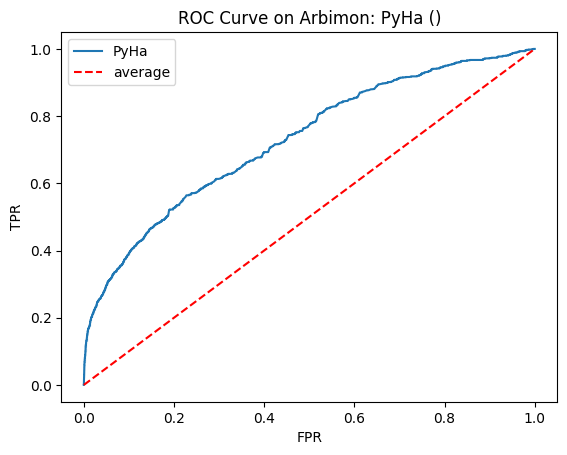

In [ ]:
from torchmetrics import ROC
import seaborn as sns
roc = ROC(task="binary")
fpr, tpr, thresholds = roc(
    torch.flatten(out_for_score),
    torch.flatten(labels_for_score)
)
sns.lineplot(x=fpr, y=tpr, label='PyHa')
sns.lineplot(x=[0, 1], y=[0, 1], linestyle='--', color='red', label='average')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title("ROC Curve on Arbimon: PyHa ()")




